# Combining `.csv`'s, Overall Annotations Data

In [1]:
import pandas as pd
import os
from glob import glob
from pathlib import Path

cwd = Path.cwd()
annotations_dir = cwd / "Annotations"

# If current path does not end in "Annotations", move into it
if cwd.name != "Annotations":
    if annotations_dir.exists():
        os.chdir(annotations_dir)
        print(f"Changed working directory to: {annotations_dir}")
    else:
        raise FileNotFoundError(f"'Annotations' directory not found at: {annotations_dir}")
else:
    print("Already in Annotations directory.")

Changed working directory to: /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/Annotations


In [2]:
# # Need to run only once 
# all_csv_files = glob(os.path.join(newcwd, '*.csv'))

# df_list = []

# for file in all_csv_files:
#     df = pd.read_csv(file)
    
#     # Get filename without extension
#     sample_id = os.path.splitext(os.path.basename(file))[0]
    
#     # Add a sample_id column
#     df['sample_id'] = sample_id
    
#     # Optional: create a unique global pixel ID
#     df['global_pixel_id'] = df['sample_id'] + '_' + df['ID'].astype(str)
    
#     df_list.append(df)

# # Combine all data
# combined_df = pd.concat(df_list, ignore_index=True)

# # Optional: Reorder columns for readability
# cols = ['global_pixel_id', 'sample_id', 'ID', 'Label'] + [c for c in combined_df.columns if c not in ['global_pixel_id', 'sample_id', 'ID', 'Label']]
# combined_df = combined_df[cols]

# # Save to master file
# combined_df.to_csv(os.path.join(newcwd, 'combined_annotations.csv'), index=False)

# Label Harmonisation

In [3]:
combined = pd.read_csv('combined_annotations.csv')
print(f'Unique labels in the combined dataset: {combined['Label'].unique()}')

Unique labels in the combined dataset: ['CIN1' 'NORMAL' 'CGIN' 'Normal' 'normal' 'CIN2' 'HPV INFECTION'
 'normal 1']


In [4]:
# Combine various normal labels into one label
combined_copy = combined.copy()
# Then apply mapping to standard labels
harmonised_map = {
    'NORMAL': 'Normal',
    'normal': 'Normal',
    'normal 1': 'Normal',
}

# Only replace known variants, leave others untouched
combined_copy['Label'] = combined_copy['Label'].replace(harmonised_map)

# Check the first few entries of the reformatted DataFrame
display(combined_copy.head())
print(f'Updated unique labels in the combined dataset: {combined_copy['Label'].unique()}')

,global_pixel_id,sample_id,ID,Label,50.0094401672363,50.0688464477539,50.2138850524902,50.2588908508301,50.2893893554688,50.3882090881348,...,1196.19197724609,1196.94295380859,1197.12715791016,1197.53121064453,1198.50252412109,1198.84285615234,1199.32515595703,1199.60176728516,1199.99214814453,1200.48873017578
0,MK484_CSV_1,MK484_CSV,1,CIN1,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,MK484_CSV_2,MK484_CSV,2,CIN1,0.0,0.0,0.0,0.0,0.0,0.000000,...,104.948468,104.948468,104.948468,73.945946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,MK484_CSV_3,MK484_CSV,3,CIN1,0.0,0.0,0.0,0.0,0.0,8.024724,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,MK484_CSV_4,MK484_CSV,4,CIN1,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,MK484_CSV_5,MK484_CSV,5,CIN1,0.0,0.0,0.0,0.0,0.0,0.000000,...,231.247212,231.247212,231.247212,228.784299,211.314571,211.314571,120.310658,120.310658,120.310658,120.310658


Updated unique labels in the combined dataset: ['CIN1' 'Normal' 'CGIN' 'CIN2' 'HPV INFECTION']


# Preliminary Analysis

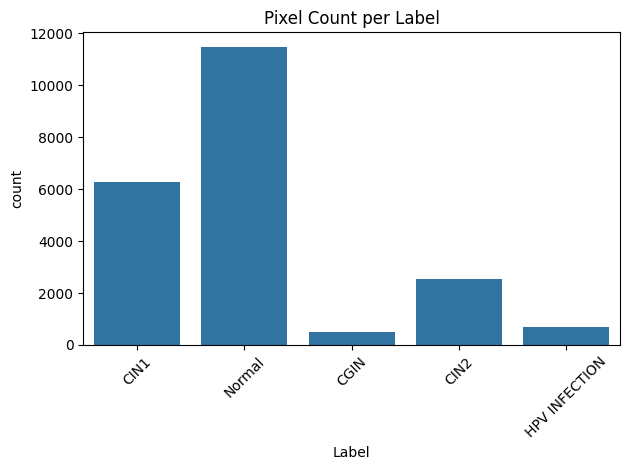

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=combined_copy, x='Label')
plt.title('Pixel Count per Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

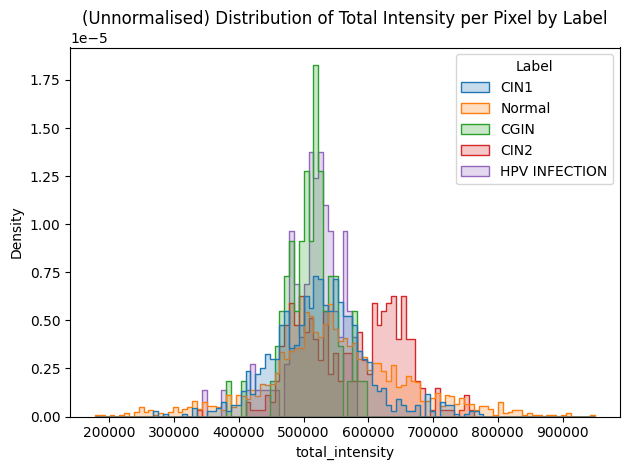

In [6]:
import numpy as np

# Drop non-feature columns
feature_cols = [col for col in combined_copy.columns if col not in ['ID', 'Label', 'sample_id', 'global_pixel_id']]

# Compute total intensity per pixel
combined_copy['total_intensity'] = combined_copy[feature_cols].sum(axis=1)

# Plot histogram of total intensity by Label
sns.histplot(data=combined_copy, x='total_intensity', hue='Label', element='step', stat='density', common_norm=False)
plt.title('(Unnormalised) Distribution of Total Intensity per Pixel by Label')
plt.tight_layout()
plt.show()

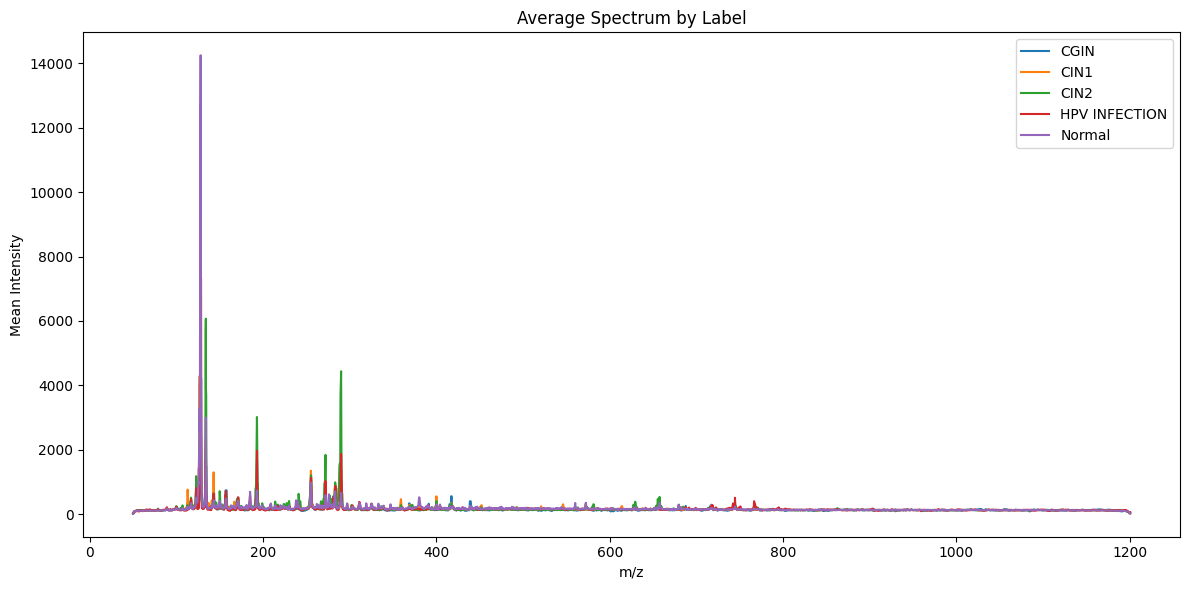

In [7]:
# Group by Label and compute mean spectrum
mean_spectra = combined_copy.groupby('Label')[feature_cols].mean().T

# Plot average spectra
plt.figure(figsize=(12, 6))
for label in mean_spectra.columns:
    plt.plot(mean_spectra.index.astype(float), mean_spectra[label], label=label)

plt.title('Average Spectrum by Label')
plt.xlabel('m/z')
plt.ylabel('Mean Intensity')
plt.legend()
# plt.xlim(600, 800)
# plt.ylim(0,1000)
plt.tight_layout()
plt.show()

# TIC Normalisation

In [8]:
import numpy as np

# Define spectral feature columns (exclude metadata)
features = [col for col in combined_copy.columns 
            if col not in ['global_pixel_id', 'ID', 'Label', 'sample_id', 'total_intensity']]

# Compute TIC per spectrum (row sum)
tic = combined_copy[features].sum(axis=1)

# Avoid division by zero (just in case)
tic = tic.replace(0, np.nan)

# Perform TIC normalization
combined_copy.loc[:, features] = combined_copy[features].div(tic, axis=0)

display(combined_copy)

,global_pixel_id,sample_id,ID,Label,50.0094401672363,50.0688464477539,50.2138850524902,50.2588908508301,50.2893893554688,50.3882090881348,...,1196.94295380859,1197.12715791016,1197.53121064453,1198.50252412109,1198.84285615234,1199.32515595703,1199.60176728516,1199.99214814453,1200.48873017578,total_intensity
0,MK484_CSV_1,MK484_CSV,1,CIN1,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,550425.571294
1,MK484_CSV_2,MK484_CSV,2,CIN1,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000203,0.000203,1.433516e-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,515836.238801
2,MK484_CSV_3,MK484_CSV,3,CIN1,0.0,0.0,0.0,0.000000,0.000000,0.000015,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,518125.479751
3,MK484_CSV_4,MK484_CSV,4,CIN1,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,536273.189392
4,MK484_CSV_5,MK484_CSV,5,CIN1,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000449,0.000449,4.444038e-04,0.000410,0.000410,0.000234,0.000234,0.000234,0.000234,514811.710411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21450,MK521_CIN1_365,MK521_CIN1,365,Normal,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000149,0.000149,1.004899e-04,0.000547,0.000741,0.000847,0.000439,0.000000,0.000000,518857.900997
21451,MK521_CIN1_366,MK521_CIN1,366,Normal,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000360,0.000360,2.423784e-04,0.000215,0.000000,0.000000,0.000000,0.000000,0.000000,506240.734005
21452,MK521_CIN1_367,MK521_CIN1,367,Normal,0.0,0.0,0.0,0.000227,0.000227,0.000173,...,0.000205,0.000205,4.808480e-04,0.000975,0.000861,0.000306,0.000075,0.000000,0.000000,495955.854285
21453,MK521_CIN1_368,MK521_CIN1,368,Normal,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000148,0.000148,1.862697e-04,0.000320,0.000316,0.000199,0.000083,0.000000,0.000000,526568.135775


# Log-Median Transform

In [9]:
# Apply log transform
log_transformed = np.log1p(combined_copy[features])

# Subtract row-wise median
row_medians = log_transformed.median(axis=1)
log_med_normalized = log_transformed.subtract(row_medians, axis=0)

# Store transformed features separately if needed
combined_copy_logmed = combined_copy.copy()
combined_copy_logmed[features] = log_med_normalized

In [10]:
import os
from pathlib import Path

cwd = Path.cwd()
parent_dir = cwd.parent  # one level above current directory

save_dir = parent_dir / "PreppedData"
os.makedirs(save_dir, exist_ok=True)  # create folder if not exists

# Extract feature matrix (as numpy array)
X = combined_copy_logmed[features].values

# Define label mapping explicitly
label_mapping = {
    'Normal': 0,
    'CIN1': 1,
    'CIN2': 2,
    'CGIN': 3,
    'HPV INFECTION': 4
}

# Extract labels
y_raw = combined_copy_logmed['Label'].values

# Map string labels to integers using mapping
y_encoded = combined_copy_logmed['Label'].map(label_mapping)

# Check for unmapped labels
if y_encoded.isnull().any():
    missing = combined_copy_logmed.loc[y_encoded.isnull(), 'Label'].unique()
    raise ValueError(f"Found unmapped labels: {missing}")

# Convert to integer numpy array
y_encoded = y_encoded.astype(int).values

# Save both to a single compressed npz file inside save_dir
np.savez_compressed(save_dir / 'combined_logmed_transformed.npz', X=X, y=y_encoded)
print(f"Saved compressed data to '{save_dir / 'combined_logmed_transformed.npz'}'")

Saved compressed data to '/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/PreppedData/combined_logmed_transformed.npz'


In [11]:
display(combined_copy_logmed.head())
print(combined_copy_logmed['Label'].isna().sum())

,global_pixel_id,sample_id,ID,Label,50.0094401672363,50.0688464477539,50.2138850524902,50.2588908508301,50.2893893554688,50.3882090881348,...,1196.94295380859,1197.12715791016,1197.53121064453,1198.50252412109,1198.84285615234,1199.32515595703,1199.60176728516,1199.99214814453,1200.48873017578,total_intensity
0,MK484_CSV_1,MK484_CSV,1,CIN1,-0.000216,-0.000216,-0.000216,-0.000216,-0.000216,-0.000216,...,-0.000216,-0.000216,-0.000216,-0.000216,-0.000216,-2.158875e-04,-2.158875e-04,-2.158875e-04,-2.158875e-04,550425.571294
1,MK484_CSV_2,MK484_CSV,2,CIN1,-0.000216,-0.000216,-0.000216,-0.000216,-0.000216,-0.000216,...,-0.000013,-0.000013,-0.000073,-0.000216,-0.000216,-2.160167e-04,-2.160167e-04,-2.160167e-04,-2.160167e-04,515836.238801
2,MK484_CSV_3,MK484_CSV,3,CIN1,-0.000235,-0.000235,-0.000235,-0.000235,-0.000235,-0.000220,...,-0.000235,-0.000235,-0.000235,-0.000235,-0.000235,-2.352870e-04,-2.352870e-04,-2.352870e-04,-2.352870e-04,518125.479751
3,MK484_CSV_4,MK484_CSV,4,CIN1,-0.000215,-0.000215,-0.000215,-0.000215,-0.000215,-0.000215,...,-0.000215,-0.000215,-0.000215,-0.000215,-0.000215,-2.149354e-04,-2.149354e-04,-2.149354e-04,-2.149354e-04,536273.189392
4,MK484_CSV_5,MK484_CSV,5,CIN1,-0.000233,-0.000233,-0.000233,-0.000233,-0.000233,-0.000233,...,0.000216,0.000216,0.000211,0.000177,0.000177,6.189902e-07,6.189902e-07,6.189902e-07,6.189902e-07,514811.710411


0


# PCA

Should ideally be done after the data has been prepped for CV. Here, just a proof of concept.

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import combinations

# Standardise the feature data
X_scaled = StandardScaler().fit_transform(combined_copy_logmed[features])
#X_scaled = combined_copy_logmed[features]
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

In [12]:
# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])
pca_df['Label'] = combined_copy['Label'].values

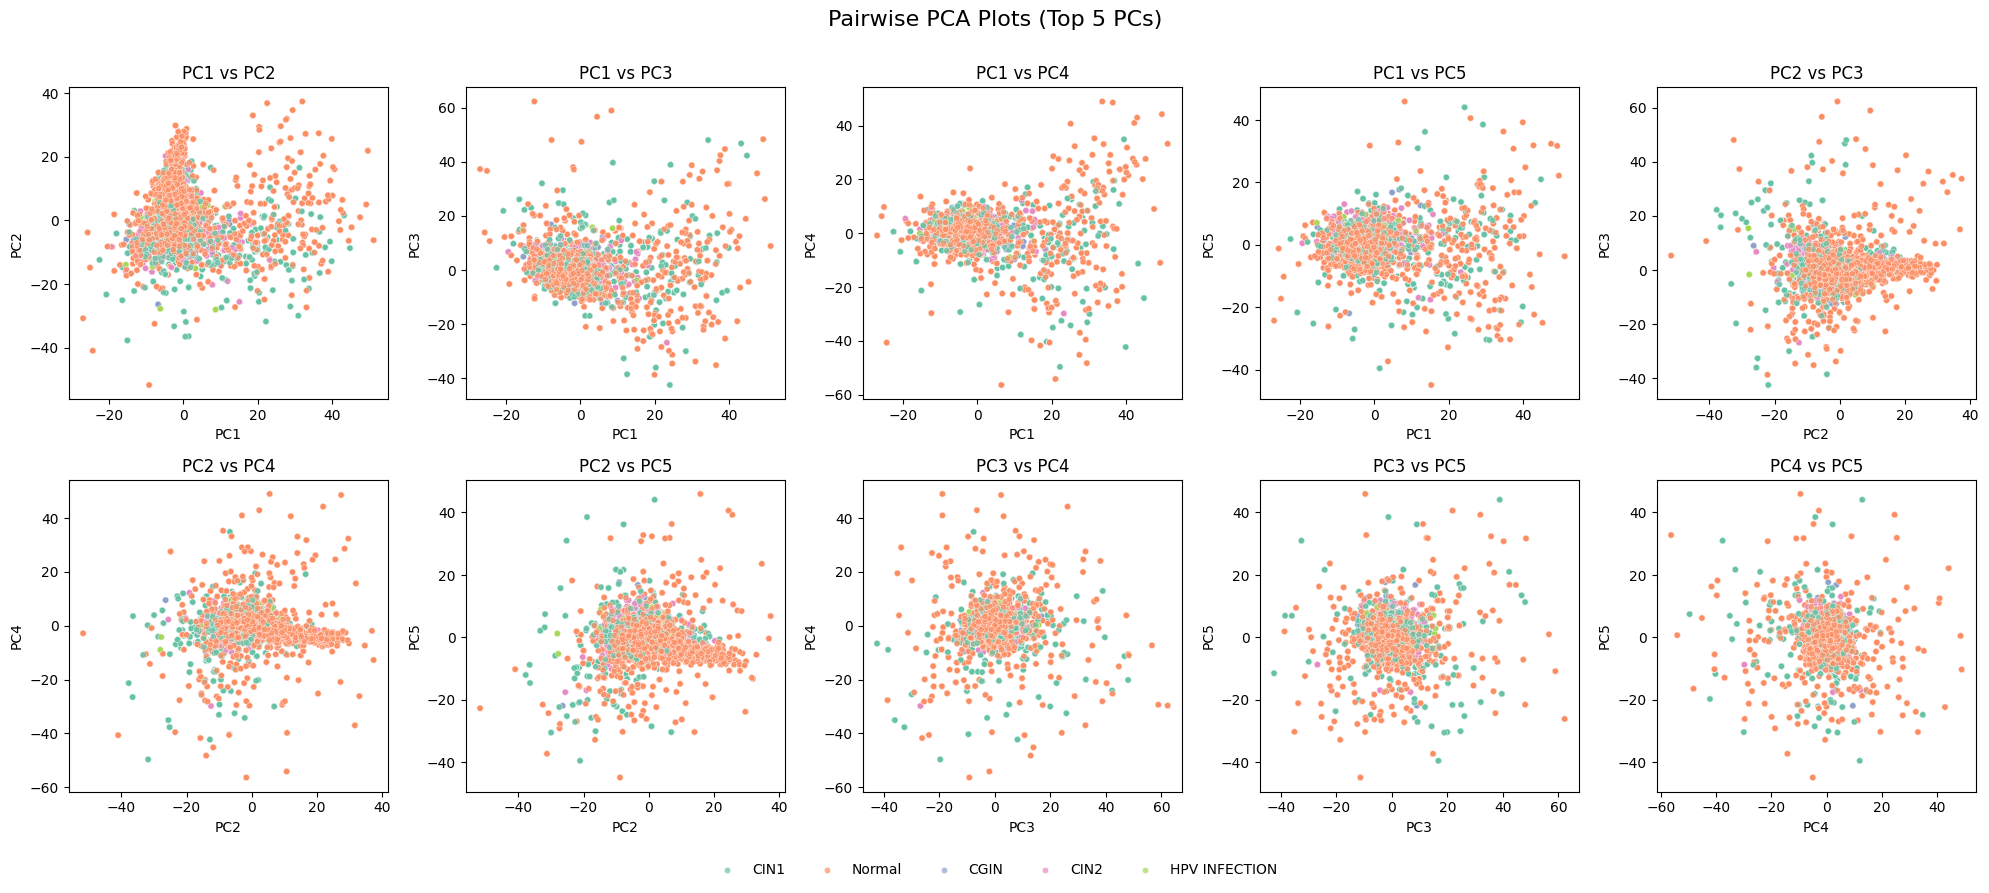

In [13]:
# Plot all 10 PC pair combinations
pc_pairs = list(combinations(range(5), 2))
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (pc1, pc2) in enumerate(pc_pairs):
    sns.scatterplot(
        data=pca_df,
        x=f'PC{pc1+1}', y=f'PC{pc2+1}',
        hue='Label',
        ax=axes[i], palette='Set2', s=20, alpha=0.7
    )
    axes[i].set_title(f'PC{pc1+1} vs PC{pc2+1}')
    axes[i].legend().set_visible(False)  # Hide legends for cleanliness

# Add global legend, moved down with some spacing
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=len(labels),
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  # X=0.5 (center), Y below the plot area (-0.05)
)
plt.tight_layout()
plt.suptitle("Pairwise PCA Plots (Top 5 PCs)", fontsize=16, y=1.05)
plt.show()

In [14]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio per PC:", explained_variance_ratio)
print("Cumulative explained variance:", explained_variance_ratio.cumsum())

Explained variance ratio per PC: [0.0310225  0.02643805 0.0191785  0.01656791 0.01468838]
Cumulative explained variance: [0.0310225  0.05746054 0.07663904 0.09320696 0.10789534]


# Redo PCA to capture 95% variance in data

Should ideally be done after the data has been prepped for CV. Here, just a proof of concept.

In [15]:
# Standardise the feature data
X_scaled_final = StandardScaler().fit_transform(combined_copy_logmed[features])
#X_scaled = combined_copy_logmed[features]
pca95 = PCA(n_components=0.95)
X_pca95 = pca95.fit_transform(X_scaled_final)

In [16]:
explained_variance_ratio95 = pca95.explained_variance_ratio_
print("Explained variance ratio per PC:", len(explained_variance_ratio95))

Explained variance ratio per PC: 862


# Saving pre-processed data

In [17]:
import numpy as np
import os
import pandas as pd

# Define label mapping explicitly
label_mapping = {
    'Normal': 0,
    'CIN1': 1,
    'CIN2': 2,
    'CGIN': 3,
    'HPV INFECTION': 4
}

# Extract labels
y_raw = combined_copy_logmed['Label'].values

# Map string labels to integers using  mapping
y_encoded = combined_copy_logmed['Label'].map(label_mapping).values

# Features from PCA
X = X_pca95

print("Label mapping:", label_mapping)
print("X shape:", X.shape)
print("y shape:", y_encoded.shape)
print("Unique encoded labels:", np.unique(y_encoded))

Label mapping: {'Normal': 0, 'CIN1': 1, 'CIN2': 2, 'CGIN': 3, 'HPV INFECTION': 4}
X shape: (21455, 862)
y shape: (21455,)
Unique encoded labels: [0 1 2 3 4]


In [18]:
# Save folder
save_dir = os.path.join(cwd, 'PreppedData')
os.makedirs(save_dir, exist_ok=True)

# Save compressed npz file with both X and y
np.savez_compressed(os.path.join(save_dir, 'data_compressed.npz'), X=X, y=y_encoded)
print(f"Saved compressed data to '{os.path.join(save_dir, 'data_compressed.npz')}'")

Saved compressed data to '/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/PreppedData/data_compressed.npz'
